In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import *
from keras.models import Model
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

Using TensorFlow backend.


In [2]:
BASE_PATH = "Dataset/AnimalDataset/All_Images"

folders = os.listdir(BASE_PATH)
print(folders)

['cats', 'dogs', 'horses', 'humans']


In [3]:
image_data = []
labels = []

label_dict = {
    "cats":0,
    "dogs":1,
    "horses":2,
    "humans":3
}

In [4]:
for ix in folders:
    path = os.path.join(BASE_PATH, ix)
    
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im), target_size=((224,224)))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[ix])

In [5]:
print(len(image_data), len(labels))

808 808


In [6]:
combined = list(zip(image_data, labels))
random.shuffle(combined)
image_data[:], labels[:] = zip(*combined)

In [7]:
X_train = np.array(image_data)
Y_train = np.array(labels)

print(X_train.shape, Y_train.shape)

(808, 224, 224, 3) (808,)


In [8]:
Y_train = np_utils.to_categorical(Y_train)
print(X_train.shape, Y_train.shape)

(808, 224, 224, 3) (808, 4)


### Create The ResNet 50 Model

In [9]:
model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [10]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
av1 = GlobalAveragePooling2D()(model.output) # Global Average Pooling (GAP) -> Each Channel Will Be Replaced With A Scalar
fc1 = Dense(256, activation='relu')(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(4, activation='softmax')(d1)

In [12]:
# Keras Functional API
model_new = Model(input=model.input, outputs=fc2)

In [13]:
# End-to-End Trainable Model
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

### Fine Tuning

In [14]:
adam = Adam(lr=0.00003)
model_new.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])

In [15]:
for ix in range(len(model_new.layers)):
    print(ix, model_new.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x00000235CBD1F488>
1 <keras.layers.convolutional.ZeroPadding2D object at 0x00000235AE21BAC8>
2 <keras.layers.convolutional.Conv2D object at 0x00000235AE21C408>
3 <keras.layers.normalization.BatchNormalization object at 0x00000235AE21AC08>
4 <keras.layers.core.Activation object at 0x00000235CBD48E08>
5 <keras.layers.convolutional.ZeroPadding2D object at 0x00000235E8D6E408>
6 <keras.layers.pooling.MaxPooling2D object at 0x00000235E907CC48>
7 <keras.layers.convolutional.Conv2D object at 0x00000235E9084BC8>
8 <keras.layers.normalization.BatchNormalization object at 0x00000235E9088548>
9 <keras.layers.core.Activation object at 0x00000235E9088988>
10 <keras.layers.convolutional.Conv2D object at 0x00000235E908C388>
11 <keras.layers.normalization.BatchNormalization object at 0x00000235E90A8C88>
12 <keras.layers.core.Activation object at 0x00000235E90B5388>
13 <keras.layers.convolutional.Conv2D object at 0x00000235E90C2308>
14 <keras.layers.conv

In [16]:
# Lets Fine Tune Only The Last Conv Layer Of The Conv Base,
# i.e layer no. 171. Before Layer 171, Every Things Is Freezed.

for ix in range(169):
    model_new.layers[ix].trainable = False
    
model_new.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

Total params: 24,113,284
Trainable params: 1,581,316
Non-trainable params: 22,531,968
__________________________________________________________________________________________________


In [17]:
hist = model_new.fit(X_train, Y_train, shuffle=True, batch_size=16, epochs=9, validation_split=0.2)

Train on 646 samples, validate on 162 samples
Epoch 1/9
646/646 [==============================] - 125s 193ms/step - loss: 1.2821 - accuracy: 0.4474 - val_loss: 0.6734 - val_accuracy: 0.7284
Epoch 2/9
646/646 [==============================] - 124s 192ms/step - loss: 0.6848 - accuracy: 0.7492 - val_loss: 0.3447 - val_accuracy: 0.9198
Epoch 3/9
646/646 [==============================] - 131s 203ms/step - loss: 0.4551 - accuracy: 0.8607 - val_loss: 0.2281 - val_accuracy: 0.9568
Epoch 4/9
646/646 [==============================] - 130s 202ms/step - loss: 0.3128 - accuracy: 0.9164 - val_loss: 0.1685 - val_accuracy: 0.9691
Epoch 5/9
646/646 [==============================] - 130s 202ms/step - loss: 0.2561 - accuracy: 0.9303 - val_loss: 0.1539 - val_accuracy: 0.9691
Epoch 6/9
646/646 [==============================] - 130s 202ms/step - loss: 0.2215 - accuracy: 0.9288 - val_loss: 0.1247 - val_accuracy: 0.9753
Epoch 7/9
646/646 [==============================] - 205s 317ms/step - loss: 0.1844 

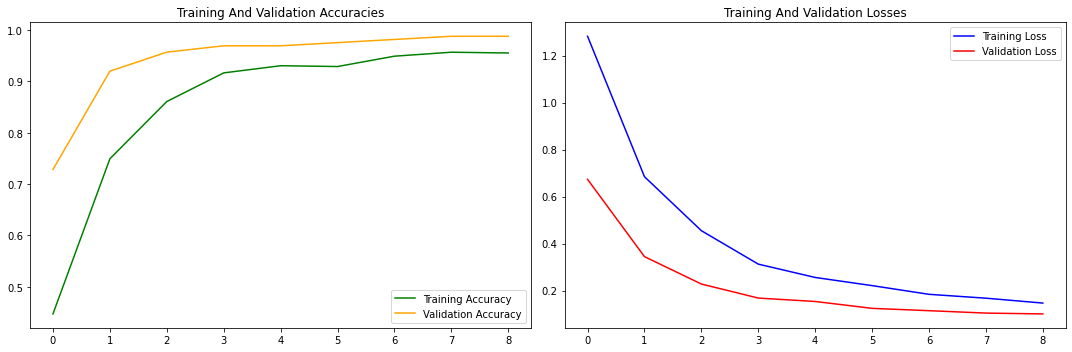

In [18]:
train_acc = hist.history["accuracy"]
valid_acc = hist.history["val_accuracy"]
train_loss = hist.history["loss"]
valid_loss = hist.history["val_loss"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_acc, label="Training Accuracy", color="green")
plt.plot(valid_acc, label="Validation Accuracy", color="orange")
plt.legend()
plt.title("Training And Validation Accuracies")
plt.subplot(1,2,2)
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(valid_loss, label="Validation Loss", color="red")
plt.legend()
plt.title("Training And Validation Losses")
plt.tight_layout()
plt.show()

In [19]:
train_loss, train_acc = model_new.evaluate(X_train, Y_train)
print("\nTraining Accuracy : ", round(100*train_acc, 2), "%")

808/808 [==============================] - 144s 178ms/step

Training Accuracy :  97.77 %
